In [1]:
import sys
sys.path.insert(0,'../')

# DATA

In [2]:
import numpy as np
import pylab as plt
from os import path
from glob import glob
from tqdm import tqdm
# from skimage.io import imread
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tqdm.keras import TqdmCallback
from sklearn.model_selection import train_test_split

import tfcook as tfc

In [18]:
image_size = 32

if path.exists("data.npz"):
    data = np.load('data.npz')
    x = data['x']
    y = data['y']
    n_class = len(np.unique(y))
else:
    import tensorflow_datasets as tfds
    ds = tfds.load('RockPaperScissors', split='train', shuffle_files=True)
    elms = []
    ii = 0
    for element in ds.as_numpy_iterator(): 
        elms.append(element) 
    #     if ii>10: break
    x = []
    y = []
    for i in range(len(elms)):
        x.append(elms[i]['image'])
        y.append(elms[i]['label'])
    x = np.array(x)
    y = np.array(y)
    xp = []
    for xi in x:
        xp.append(resize(xi,(image_size,image_size),preserve_range=1))
    x = np.array(xp)

    x = x.astype(np.float32)/255
    y = y.astype(int)

    labels = np.unique(y)
    n_class = len(labels)
    labelmap = {j:i for i,j in enumerate(labels)}
    y = [labelmap[i] for i in y]
    y = np.array(y)
    np.savez('data',x=x,y=y)


(2520, 32, 32, 3) (2520,) (2394, 32, 32, 3) (2394,) (126, 32, 32, 3) (126,)


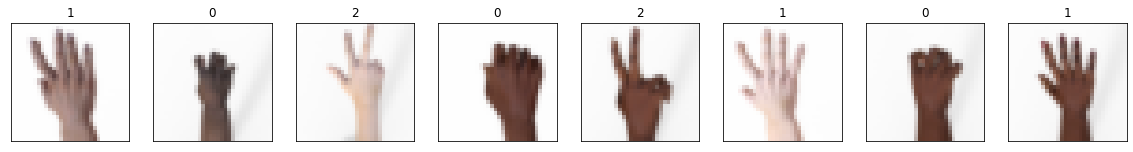

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.95,random_state=42)

print(x.shape,y.shape,x_test.shape,y_test.shape,x_train.shape,y_train.shape)

image_size = x.shape[1]

fig,axs = plt.subplots(1,8,figsize=(20,6))
for i in range(8):
    ii = np.random.randint(x.shape[0])
    ax = axs[i]
    ax.imshow(x[ii])
    ax.set_title(y[ii])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [20]:
image_channels = x.shape[3]

n_latent = image_size
num_epochs = 100

In [21]:
batch_size = 128
classification_augmentation = {'input_shape':(image_size, image_size, image_channels),"min_area": 0.75, "brightness": 0.3, "jitter": 0.1}

labeled_train_dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train))
                            .shuffle(buffer_size=10 * batch_size)
                            .batch(batch_size)
                        )

test_dataset = (tf.data.Dataset.from_tensor_slices((x_test, y_test))
                  .shuffle(buffer_size=10 * batch_size)
                  .batch(batch_size)
                )

labeled_dataset_size = y_train.shape[0]

# Classic trainintg

In [22]:
encoder1 = tfc.get_encoder(input_shape=(image_size, image_size, image_channels),nfilter=n_latent)

inp = keras.layers.Input(shape=(image_size, image_size, image_channels))
xl = tfc.get_augmenter(**classification_augmentation)(inp)
for layer in encoder1.layers:
    xl = layer(xl)
out = layers.Dense(n_class)(xl)
model1 = keras.models.Model(inp,out,name='model1')
model1.summary()

Model: "model1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 3, 3, 32)          9248      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 1, 1, 32)          9248      
_________________________________________________________________
flatten_2 (Flatten)          (None, 32)                0    

In [23]:
# # Baseline supervised training with random initialization
# baseline_model = keras.Sequential(
#     [
#         keras.layers.InputLayer(input_shape=(image_size, image_size, image_channels)),
#         get_augmenter(**classification_augmentation),
#         get_encoder(input_shape=(image_size, image_size, image_channels),nfilter=n_latent),
#         layers.Dense(n_class),
#     ],
#     name="baseline_model",
# )

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                             initial_learning_rate=1e-3,
                             decay_steps=50,
                             decay_rate=0.95)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model1.compile(
    optimizer=opt,
#     loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
#     metrics=[tf.keras.metrics.CategoricalAccuracy(name="acc")]
)

In [24]:
model1.summary()

Model: "model1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 3, 3, 32)          9248      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 1, 1, 32)          9248      
_________________________________________________________________
flatten_2 (Flatten)          (None, 32)                0    

In [1]:
history1 = model1.fit(labeled_train_dataset,
                      epochs=num_epochs,
                      validation_data=test_dataset,
                      verbose=0,
                      callbacks=[TqdmCallback(verbose=0)]
                      )

# SimCLR

In [27]:
encoder2 = tfc.get_encoder(input_shape=(image_size, image_size, image_channels),nfilter=n_latent)

inp = keras.layers.Input(shape=(image_size, image_size, image_channels))
xl = tfc.get_augmenter(**classification_augmentation)(inp)
for layer in encoder2.layers:
    xl = layer(xl)
out = layers.Dense(n_class)(xl)
model2 = keras.models.Model(inp,out,name='model2')

In [28]:
batch_size_simclr = 512

encoder2 = tfc.simclr_wartmup(encoder2,x,batch_size_simclr,3*num_epochs)

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 15, 15, 32)        896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 7, 7, 32)          9248      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 3, 3, 32)          9248      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 1, 1, 32)          9248      
_________________________________________________________________
flatten_3 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
Total params: 29,696
Trainable params: 29,696
Non-trainable params: 0
_______________________________________________________

0epoch [00:00, ?epoch/s]

In [29]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                             initial_learning_rate=1e-3,
                             decay_steps=50,
                             decay_rate=0.95)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model2.compile(optimizer=opt,
                         loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                         metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
                         )

history2 = model2.fit(labeled_train_dataset,
                      epochs=num_epochs,
                      validation_data=test_dataset,
                      verbose=0,
                      callbacks=[TqdmCallback(verbose=0)]
                      )

0epoch [00:00, ?epoch/s]

# Barlow Twins

In [36]:
encoder3 = tfc.get_encoder(input_shape=(image_size, image_size, image_channels),nfilter=n_latent)

inp = keras.layers.Input(shape=(image_size, image_size, image_channels))
xl = tfc.get_augmenter(**classification_augmentation)(inp)
for layer in encoder3.layers:
    xl = layer(xl)
out = layers.Dense(n_class)(xl)
model3 = keras.models.Model(inp,out,name='model2')

In [37]:
batch_size_bt = 128

encoder3 = tfc.barlow_twins_wartmup(encoder3,x,batch_size_bt,3*num_epochs)

0epoch [00:00, ?epoch/s]

In [38]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                             initial_learning_rate=1e-3,
                             decay_steps=50,
                             decay_rate=0.95)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model3.compile(optimizer=opt,
               loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
              )

history3 = model3.fit(labeled_train_dataset,
                      epochs=num_epochs,
                      validation_data=test_dataset,
                      verbose=0,
                      callbacks=[TqdmCallback(verbose=0)]
                     )

0epoch [00:00, ?epoch/s]

### BYOL

In [40]:
encoder4 = tfc.get_encoder(input_shape=(image_size, image_size, image_channels),nfilter=n_latent)

inp = keras.layers.Input(shape=(image_size, image_size, image_channels))
xl = tfc.get_augmenter(**classification_augmentation)(inp)
for layer in encoder4.layers:
    xl = layer(xl)
out = layers.Dense(n_class)(xl)
model4 = keras.models.Model(inp,out,name='model2')

In [41]:
batch_size_byol = 128

encoder4 = tfc.byol_warmup(encoder4,x,batch_size_byol,3*num_epochs)

  0%|          | 0/5700 [00:00<?, ?it/s]

In [42]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                             initial_learning_rate=1e-3,
                             decay_steps=50,
                             decay_rate=0.95)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model4.compile(optimizer=opt,
                         loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                         metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
                         )


history4 = model4.fit(labeled_train_dataset,
                      epochs=num_epochs,
                      validation_data=test_dataset,
                      verbose=0,
                      callbacks=[TqdmCallback(verbose=0)]
                     )

0epoch [00:00, ?epoch/s]

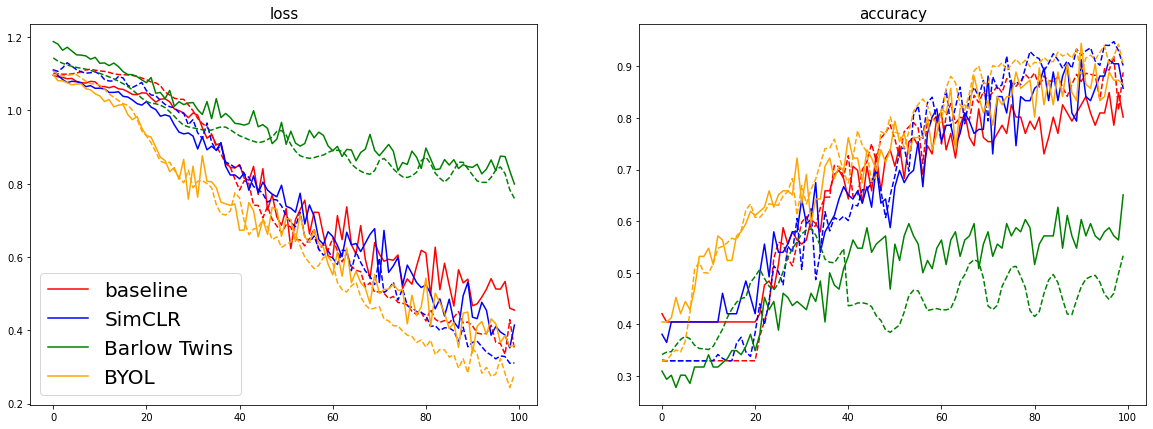

In [43]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,7))

hist = history1.history
label = 'baseline'
color = 'r'

ax1.plot(hist['loss'],color=color,label=label)
ax1.plot(hist['val_loss'],color=color,ls='--')
ax1.set_title('loss',fontsize=15)

ax2.plot(hist['acc'],color=color)
ax2.plot(hist['val_acc'],color=color,ls='--')
ax2.set_title('accuracy',fontsize=15)

hist = history2.history
label = 'SimCLR'
color = 'b'

ax1.plot(hist['loss'],color=color,label=label)
ax1.plot(hist['val_loss'],color=color,ls='--')
ax1.set_title('loss',fontsize=15)

ax2.plot(hist['acc'],color=color)
ax2.plot(hist['val_acc'],color=color,ls='--')
ax2.set_title('accuracy',fontsize=15)

hist = history3.history
label = 'Barlow Twins'
color = 'g'

ax1.plot(hist['loss'],color=color,label=label)
ax1.plot(hist['val_loss'],color=color,ls='--')
ax1.set_title('loss',fontsize=15)

ax2.plot(hist['acc'],color=color)
ax2.plot(hist['val_acc'],color=color,ls='--')
ax2.set_title('accuracy',fontsize=15)

hist = history4.history
label = 'BYOL'
color = 'orange'

ax1.plot(hist['loss'],color=color,label=label)
ax1.plot(hist['val_loss'],color=color,ls='--')
ax1.set_title('loss',fontsize=15)

ax2.plot(hist['acc'],color=color)
ax2.plot(hist['val_acc'],color=color,ls='--')
ax2.set_title('accuracy',fontsize=15)

ax1.legend(fontsize=20)